In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Pfad zur heruntergeladenen Datei
file_path = 'C:\\Users\\linag\\Downloads\\churn_data_encoded.csv'

# CSV-Datei laden
data = pd.read_csv(file_path)

# Überblick über die kodierten Daten
print("\nErste 5 Zeilen der kodierten Daten:")
print(data.head())

# Sicherstellen, dass die Zielvariable korrekt kodiert ist
if 'Churn_Yes' in data.columns:
    y = data['Churn_Yes']
else:
    for col in data.columns:
        if 'Churn' in col:
            y = data[col]
            break



Erste 5 Zeilen der kodierten Daten:
   Churn  Gender  Age  Under 30  Senior Citizen  Married  Dependents  \
0      0       0   36         0               0        1           0   
1      0       1   46         0               0        0           0   
2      1       1   37         0               0        0           0   
3      0       1   53         0               0        0           0   
4      1       0   19         1               0        0           1   

   Number of Dependents  Zip Code   Latitude  ...  Offer_Offer E  \
0                     0     90001  33.973616  ...           True   
1                     0     90002  33.949255  ...          False   
2                     0     90003  33.964131  ...          False   
3                     0     90004  34.076259  ...          False   
4                     2     90005  34.059281  ...          False   

   Internet Type_Cable  Internet Type_DSL  Internet Type_Fiber Optic  \
0                False               True        

In [2]:
# Korrelationen berechnen
correlations = data.corr()
sorted_correlations = correlations['Churn'].abs().sort_values(ascending=False)
print(sorted_correlations)

# Features definieren
X = data.drop(y.name, axis=1)


Churn                         1.000000
Satisfaction Score            0.754649
Contract_Month-to-Month       0.448427
Tenure in Months              0.352861
Contract_Two Year             0.328195
                                ...   
City_Sequoia National Park    0.000830
City_Wasco                    0.000830
City_Visalia                  0.000659
City_Los Angeles              0.000397
City_Ontario                  0.000136
Name: Churn, Length: 1156, dtype: float64


In [3]:
# Daten in Trainings- und Testdatensatz aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Klassen balancieren
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Daten skalieren
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


In [4]:
# Define own scoring function based on estimated FP and FN costs
def custom_score(y_true, y_pred):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total
    return score

def print_scores(scores):
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
    })
    print("Scores:\n", scores_df)

    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)

def evaluate_classification(X, y, classifier):
    custom_scorer = make_scorer(custom_score, greater_is_better=False)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_validate(
        classifier, 
        X, 
        y, 
        cv=cv, scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'custom_score': custom_scorer,
        }
    )
    
    print_scores(scores)
    return scores


In [5]:
# Support Vector Machine Modell erstellen und evaluieren
svm_model = SVC()
svm_scores = evaluate_classification(X_resampled_scaled, y_resampled, svm_model)


Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.970411   0.977914  0.962560  0.970177     -0.104469
1     2  0.977039   0.985240  0.968561  0.976829     -0.085801
2     3  0.969184   0.976658  0.961306  0.968921     -0.108157
3     4  0.979456   0.990123  0.968599  0.979243     -0.083384
4     5  0.972810   0.976857  0.968599  0.972711     -0.090030

Statistics:
                    Min      Mean       Max
accuracy      0.969184   0.97378  0.979456
precision     0.976658  0.981359  0.990123
recall        0.961306  0.965925  0.968599
f1            0.968921  0.973576  0.979243
custom_score -0.108157 -0.094368 -0.083384


In [6]:
# Add features one by one and evaluate the classifier
selected_features = []
sorted_corrs = sorted_correlations.index.drop(y.name)  # Exclude target variable

for feature in sorted_corrs:
    selected_features.append(feature)
    if len(selected_features) == 1:
        continue
    
    X_temp = pd.DataFrame(X_resampled_scaled, columns=X.columns)[selected_features]
    print("\nSelected features:", selected_features)

    clf = SVC()
    scores = evaluate_classification(X_temp, y_resampled, clf)

    if len(selected_features) == 10:
        break



Selected features: ['Satisfaction Score', 'Contract_Month-to-Month']
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.937802        1.0  0.875604  0.933677     -0.310990
1     2  0.941390        1.0  0.882709  0.937701     -0.293051
2     3  0.935952        1.0  0.871826  0.931525     -0.320242
3     4  0.943202        1.0  0.886473  0.939821     -0.283988
4     5  0.946828        1.0  0.893720  0.943878     -0.265861

Statistics:
                    Min      Mean       Max
accuracy      0.935952  0.941035  0.946828
precision          1.0       1.0       1.0
recall        0.871826  0.882066   0.89372
f1            0.931525   0.93732  0.943878
custom_score -0.320242 -0.294826 -0.265861

Selected features: ['Satisfaction Score', 'Contract_Month-to-Month', 'Tenure in Months']
Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.936594   0.939247  0.933575  0.936402     -0.196256
1     2  0.951662   0.962825  0.939541  0.9510

In [7]:
# Grid Search anwenden
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

def apply_grid_search(classifier, param_grid, X, y, cv=5, scoring='accuracy'):
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)
    print("Best hyperparameters:")
    print(grid_search.best_params_)

apply_grid_search(SVC(), param_grid, X_resampled_scaled, y_resampled, cv=5, scoring='accuracy')


Best hyperparameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


SVM Accuracy: 0.96
SVM Precision: 0.94
SVM Recall: 0.90
SVM F1-Score: 0.92


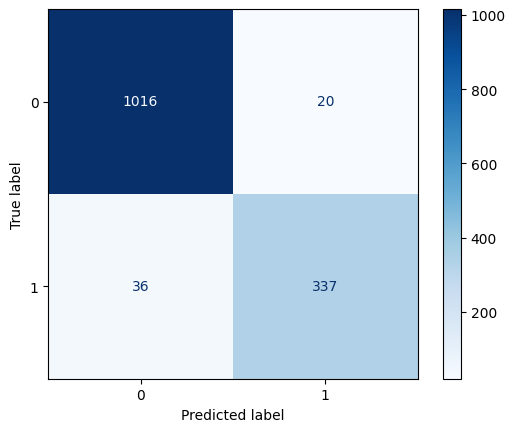

Top 20 Feature Importances:
Satisfaction Score (0.2700)
Contract_Month-to-Month (0.0320)
Number of Referrals (0.0260)
Online Security (0.0260)
Unlimited Data (0.0260)
Dependents (0.0200)
Monthly Charge (0.0180)
Internet Type_Fiber Optic (0.0160)
Referred a Friend (0.0140)
Premium Tech Support (0.0140)
Married (0.0100)
Payment Method_Mailed Check (0.0100)
Streaming Music (0.0100)
Tenure in Months (0.0080)
Device Protection Plan (0.0080)
Payment Method_Credit Card (0.0060)
Avg Monthly GB Download (0.0060)
Avg Monthly Long Distance Charges (0.0040)
Longitude (0.0040)
Total Revenue (0.0040)


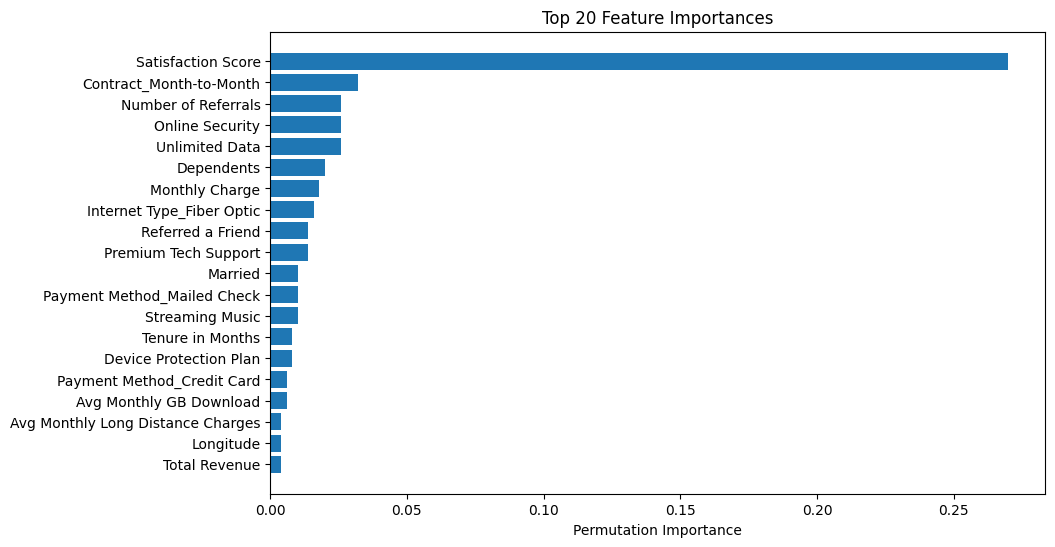

In [12]:
# SVM Modellleistung auf Testdaten bewerten
svm_model.fit(X_resampled_scaled, y_resampled)
y_pred_svm = svm_model.predict(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(f"SVM Precision: {precision_svm:.2f}")
print(f"SVM Recall: {recall_svm:.2f}")
print(f"SVM F1-Score: {f1_svm:.2f}")

# Konfusionsmatrix plotten
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_svm.plot(cmap=plt.cm.Blues)
plt.show()

# Anzahl der wichtigsten Features, die angezeigt werden sollen
num_features = 20

# Permutation Importance analysieren
sample_size = 100  # Nur eine Teilmenge der Daten verwenden
X_test_sample = X_test_scaled[:sample_size]
y_test_sample = y_test[:sample_size]

result = permutation_importance(svm_model, X_test_sample, y_test_sample, n_repeats=5, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[-num_features:]

# Die Feature Importance anzeigen
print("Top 20 Feature Importances:")
for i in sorted_idx[::-1]:
    print(f"{X.columns[i]} ({result.importances_mean[i]:.4f})")

# Plotten der wichtigsten Feature Importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.barh(range(num_features), result.importances_mean[sorted_idx], align="center")
plt.yticks(range(num_features), X.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()
